In [1]:
#######################################################################################
# builds an adaptive landscape graph from the (preprocessed) fitness data 
# in file prot_EEmutations_out.txt, performs adaptive walk simulations 
# on this graph, as well as some statistical analyses of the random walks
#######################################################################################


import EE_funcs

#to make sure that modules are reloaded after they have been edited elsewhere
import importlib 
importlib.reload(EE_funcs)

import pandas as pd

from pathlib import Path

#to be able to exit the program with sys.exit("error message")
import sys

import numpy as np
import pingouin as pg

from scipy import stats
import math
import random # for random number generators

import igraph as gr

import matplotlib.pyplot as plt


In [2]:
#########################################################
### first define which aas are accessible from each other
### needed to build the genotype network from the raw data
#########################################################

#genetic code table
dna_to_aa = {
        'ATA':'I', 'ATC':'I', 'ATT':'I', 'ATG':'M',
        'ACA':'T', 'ACC':'T', 'ACG':'T', 'ACT':'T',
        'AAC':'N', 'AAT':'N', 'AAA':'K', 'AAG':'K',
        'AGC':'S', 'AGT':'S', 'AGA':'R', 'AGG':'R',                 
        'CTA':'L', 'CTC':'L', 'CTG':'L', 'CTT':'L',
        'CCA':'P', 'CCC':'P', 'CCG':'P', 'CCT':'P',
        'CAC':'H', 'CAT':'H', 'CAA':'Q', 'CAG':'Q',
        'CGA':'R', 'CGC':'R', 'CGG':'R', 'CGT':'R',
        'GTA':'V', 'GTC':'V', 'GTG':'V', 'GTT':'V',
        'GCA':'A', 'GCC':'A', 'GCG':'A', 'GCT':'A',
        'GAC':'D', 'GAT':'D', 'GAA':'E', 'GAG':'E',
        'GGA':'G', 'GGC':'G', 'GGG':'G', 'GGT':'G',
        'TCA':'S', 'TCC':'S', 'TCG':'S', 'TCT':'S',
        'TTC':'F', 'TTT':'F', 'TTA':'L', 'TTG':'L',
        'TAC':'Y', 'TAT':'Y', 'TAA':'_', 'TAG':'_',
        'TGC':'C', 'TGT':'C', 'TGA':'_', 'TGG':'W',
    }

aa_to_dna={}
for aa in dna_to_aa.values():
    aa_to_dna[aa]=[]
    for codon in dna_to_aa.keys():
        if dna_to_aa[codon]==aa:
            aa_to_dna[aa].append(codon)

accessible_aas={}
for aa1 in aa_to_dna.keys():
    if aa1 != '_':
        accessible_aas[aa1]=[]
        for aa2 in aa_to_dna.keys():  
            if aa2 != '_' and aa2 != aa1:
                for codon1 in aa_to_dna[aa1]:
                    for codon2 in aa_to_dna[aa2]:
                        if EE_funcs.hamdist(codon1, codon2)==1 and aa2 not in accessible_aas[aa1]:
                            accessible_aas[aa1].append(aa2)
                            break 

print("\n\ntable of accessible amino acids")
for aa in accessible_aas.keys():
    print(aa, len(accessible_aas[aa]), accessible_aas[aa])


#########################################################
### extract protein data to write the genotype network from it
#########################################################

fitdatfile="protein_landscape_data.csv"
pathstr="./"
filepath = pathstr + fitdatfile
infile = Path(filepath)

df =  pd.read_csv(infile, sep=',')
fitdatall=df.T.to_dict('list')

fit={}
for n in fitdatall.keys():
    seq=fitdatall[n][0]
    fit_parE3=fitdatall[n][1]
    fit[seq]= fit_parE3
    
# a sorted list of all variable sites
allseq=sorted(fit.keys())

#determine accessible genotypes from each genotype
print("\nnow building neighborhood dictionary for each sequence")
neigh={}
tmpctr=0
for seq1 in allseq:
    #print(seq1)
    neigh[seq1]=[]
    for seq2 in allseq:
        if EE_funcs.hamdist(seq1, seq2)==1:
            for pos in range(0,3):
                if seq1[pos] != seq2[pos]:
                    break
            #print("strings differ at position ", pos, seq1[pos], seq2[pos], seq1, seq2)
            if seq2[pos] in accessible_aas[seq1[pos]]:
                #print("accessible")
                neigh[seq1].append(seq2)
            



table of accessible amino acids
I 9 ['M', 'T', 'N', 'K', 'S', 'R', 'L', 'V', 'F']
M 6 ['I', 'T', 'K', 'R', 'L', 'V']
T 8 ['I', 'M', 'N', 'K', 'S', 'R', 'P', 'A']
N 7 ['I', 'T', 'K', 'S', 'H', 'D', 'Y']
K 7 ['I', 'M', 'T', 'N', 'R', 'Q', 'E']
S 12 ['I', 'T', 'N', 'R', 'L', 'P', 'A', 'G', 'F', 'Y', 'C', 'W']
R 12 ['I', 'M', 'T', 'K', 'S', 'L', 'P', 'H', 'Q', 'G', 'C', 'W']
L 10 ['I', 'M', 'S', 'R', 'P', 'H', 'Q', 'V', 'F', 'W']
P 7 ['T', 'S', 'R', 'L', 'H', 'Q', 'A']
H 7 ['N', 'R', 'L', 'P', 'Q', 'D', 'Y']
Q 6 ['K', 'R', 'L', 'P', 'H', 'E']
V 8 ['I', 'M', 'L', 'A', 'D', 'E', 'G', 'F']
A 7 ['T', 'S', 'P', 'V', 'D', 'E', 'G']
D 7 ['N', 'H', 'V', 'A', 'E', 'G', 'Y']
E 6 ['K', 'Q', 'V', 'A', 'D', 'G']
G 8 ['S', 'R', 'V', 'A', 'D', 'E', 'C', 'W']
F 6 ['I', 'S', 'L', 'V', 'Y', 'C']
Y 6 ['N', 'S', 'H', 'D', 'F', 'C']
C 6 ['S', 'R', 'G', 'F', 'Y', 'W']
W 5 ['S', 'R', 'L', 'G', 'C']

now building neighborhood dictionary for each sequence


In [3]:
#####################################################################
# now write a graph with the fitness data
######################################################################


print("now building genotype network for adaptive walks")
gnet=gr.Graph(directed=True)
#a dictionary keyed by sequence and mapping to vertex, for faster access
seq_to_node={}
tmpctr=0
for s in allseq:
    v=gnet.add_vertex()
    seq_to_node[s]=v
    v['name']=s
    v['fit'] = fit[s]
edgearr=[]
for s1 in allseq:
    tmpctr+=1
    #print(tmpctr, s1)
    for s2 in neigh[s1]:
        if s1>s2: 
            v1=seq_to_node[s1]
            v2=seq_to_node[s2]
            edgearr.append((v1,v2))
            edgearr.append((v2,v1))
gnet.add_edges(edgearr)
for i in range(0,len(gnet.es)):
    gnet.es[i]["fitdiff"]=gnet.vs(gnet.es[i].target)['fit'][0]-gnet.vs(gnet.es[i].source)['fit'][0]
    
    

now building genotype network for adaptive walks


In [4]:
######################################################
# Next step: load the pairwise fitness data and define
# evolvability-enhancing edges
######################################################
infilename="protein_EEmutations_out.txt"
pathstr="./"

infile = pathstr + infilename
alldat =  pd.read_csv(infile, sep='\t', index_col=False)

totpairs=len(alldat)
print("total number of mutant pairs to be analyzed ", totpairs)

"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
identify beneficial, neutral, and deleterious evolvability-enhancing (EE)
evolvability neutral (EN), and evolvability reducing (ER) mutations
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

ben_EE = alldat[ (alldat["delfit"] > 0)  &  (alldat["del_neigh_fit_del_fit_0"] == 1) ] 
ben_EN = alldat[ (alldat["delfit"] > 0)  &  (alldat["del_neigh_fit_del_fit_0"] == 0) ] 
ben_ED = alldat[ (alldat["delfit"] > 0)  &  (alldat["del_neigh_fit_del_fit_0"] == -1) ] 

neut_EE = alldat[ (alldat["delfit"] == 0)  & (alldat["del_neigh_fit_del_fit_0"] == 1)   ]        
neut_EN = alldat[ (alldat["delfit"] == 0)  & (alldat["del_neigh_fit_del_fit_0"] == 0)   ]        
neut_ED = alldat[ (alldat["delfit"] == 0)  & (alldat["del_neigh_fit_del_fit_0"] == -1)   ]        

del_EE = alldat[ (alldat["delfit"] < 0)  &   (alldat["del_neigh_fit_0_0"] == 1) ]  
del_EN = alldat[ (alldat["delfit"] < 0)  &    (alldat["del_neigh_fit_0_0"] == 0)]
del_ED = alldat[ (alldat["delfit"] < 0)  &   (alldat["del_neigh_fit_0_0"] == -1) ]                                                                                                        


total number of mutant pairs to be analyzed  175552


In [5]:
#####################################################
## now assign an evolvability effect to each edge (mutation) of the graph
#####################################################

g_benEE=ben_EE.loc[:, ["wt", "mut"]].values
ben_EEctr=0
for i in range(0, len(g_benEE)):
    wt=g_benEE[i][0]
    mut=g_benEE[i][1]
    e=gnet.get_eid(seq_to_node[wt].index, seq_to_node[mut].index)
    ben_EEctr+=1
    gnet.es[e]["evolv"]="ben_EE"
    
g_benEN=ben_EN.loc[:, ["wt", "mut"]].values
ben_ENctr=0
for i in range(0, len(g_benEN)):
    wt=g_benEN[i][0]
    mut=g_benEN[i][1]
    e=gnet.get_eid(seq_to_node[wt].index, seq_to_node[mut].index)
    ben_ENctr+=1
    gnet.es[e]["evolv"]="ben_EN"

g_benED=ben_ED.loc[:, ["wt", "mut"]].values
ben_EDctr=0
for i in range(0, len(g_benED)):
    wt=g_benED[i][0]
    mut=g_benED[i][1]
    e=gnet.get_eid(seq_to_node[wt].index, seq_to_node[mut].index)
    ben_EDctr+=1
    gnet.es[e]["evolv"]="ben_ED"
      
g_neutEE=neut_EE.loc[:, ["wt", "mut"]].values
neut_EEctr=0
for i in range(0, len(g_neutEE)):
    wt=g_neutEE[i][0]
    mut=g_neutEE[i][1]
    e=gnet.get_eid(seq_to_node[wt].index, seq_to_node[mut].index)
    neut_EEctr+=1
    gnet.es[e]["evolv"]="neut_EE"

g_neutEN=neut_EN.loc[:, ["wt", "mut"]].values
neut_ENctr=0
for i in range(0, len(g_neutEN)):
    wt=g_neutEN[i][0]
    mut=g_neutEN[i][1]
    e=gnet.get_eid(seq_to_node[wt].index, seq_to_node[mut].index)
    neut_ENctr+=1
    gnet.es[e]["evolv"]="neut_EN"

g_neutED=neut_ED.loc[:, ["wt", "mut"]].values
neut_EDctr=0
for i in range(0, len(g_neutED)):
    wt=g_neutED[i][0]
    mut=g_neutED[i][1]
    e=gnet.get_eid(seq_to_node[wt].index, seq_to_node[mut].index)
    neut_EDctr+=1
    gnet.es[e]["evolv"]="neut_ED"

g_delEE=del_EE.loc[:, ["wt", "mut"]].values
del_EEctr=0
for i in range(0, len(g_delEE)):
    wt=g_delEE[i][0]
    mut=g_delEE[i][1]
    e=gnet.get_eid(seq_to_node[wt].index, seq_to_node[mut].index)
    del_EEctr+=1
    gnet.es[e]["evolv"]="del_EE"

g_delEN=del_EN.loc[:, ["wt", "mut"]].values
del_ENctr=0
for i in range(0, len(g_delEN)):
    wt=g_delEN[i][0]
    mut=g_delEN[i][1]
    e=gnet.get_eid(seq_to_node[wt].index, seq_to_node[mut].index)
    del_ENctr+=1
    gnet.es[e]["evolv"]="del_EN"

g_delED=del_ED.loc[:, ["wt", "mut"]].values
del_EDctr=0
for i in range(0, len(g_delED)):
    wt=g_delED[i][0]
    mut=g_delED[i][1]
    e=gnet.get_eid(seq_to_node[wt].index, seq_to_node[mut].index)
    del_EDctr+=1
    gnet.es[e]["evolv"]="del_ED"

    
       
    

In [6]:
#################################################################
##   now for the main routine: simulate the random walks   ######
#################################################################

#global fitness minima and maxima (for all lite data) for data normalization
minfit_lite=-0.2093
maxfit_lite=1.0175


random.seed(81919)

#effective population sizes to be explored
Narr=[1e+08, 1e+05, 1e+02]            
    
nwalks=10000
#note: differences in mean fitness were calculated in the paper for 
#a walk length of 3, but the fraction of non-terminated walks and related
#statistics were calculated for walks of length 10. To get these two
#kinds of results, this parameter needs to be modified.
walklen=3


#the percentile in the fitness distribution below which starting genotypes should be chosen
#perc=100 means they are chosen randomly without regard to fitness
perc=5
tmpfitarr=[]
for i in range(0,len(gnet.vs)):
    tmpfitarr.append(gnet.vs[i]['fit'])
thresh=np.percentile(tmpfitarr, perc)

#chose a sample of nodes whose fitness lies below the threshold
#the result is a node sequence object
node_sample=gnet.vs.select(fit_le=thresh)
print("sampling ", nwalks, "nodes from a subset of ", len(node_sample), "nodes in the ", perc, "-percentile of the fitness distribution")

simdat=[]
for N in Narr:
    #calculate the fixation probabilities along all edges before the actual random walk
    EE_funcs.pfix_gnet_Kimura(gnet, N)

    g_init=random.choices(node_sample, k=nwalks)
    for g in g_init:
        
        initfit=g['fit']
        
        #normalize fitness data to (0,1) 
        initfit=(initfit-minfit_lite)/(maxfit_lite-minfit_lite)
        #here is where the random walk proper takes place
        [finalfit, e_trav, L_actual]=EE_funcs.ranwalk_Kimura(gnet, g, walklen)
       
        #normalize fitness data to (0,1)
        finalfit=(finalfit-minfit_lite)/(maxfit_lite-minfit_lite)
        
        #write output data to an array
        deltafit=finalfit-initfit
        datrow=[N, walklen, initfit, finalfit, deltafit,\
                e_trav['EE_edges'], e_trav['EN_edges'], e_trav['ED_edges'],\
                e_trav['ben_EE_edges'], e_trav['ben_EN_edges'], e_trav['ben_ED_edges'],\
                e_trav['neut_EE_edges'], e_trav['neut_EN_edges'], e_trav['neut_ED_edges'],\
                e_trav['del_EE_edges'], e_trav['del_EN_edges'], e_trav['del_ED_edges'],\
                L_actual ]
        simdat.append(datrow)
        
#transform simulation data into a data frame
simdatdf = pd.DataFrame(simdat, columns=['N', 'walklen', 'initfit', 'finalfit', 'deltafit', 
                                         'n_EE', 'n_EN', 'n_ED',
                                         'n_ben_EE', 'n_ben_EN', 'n_ben_ED',
                                         'n_neut_EE', 'n_neut_EN', 'n_neut_ED',
                                         'n_del_EE', 'n_del_EN', 'n_del_ED',                                         
                                         'len'])





sampling  10000 nodes from a subset of  395 nodes in the  5 -percentile of the fitness distribution


In [7]:
#quantitative analyses of the adaptive walks 

#correlation between lengths of random walk and EE mutations
print("\n\n")
for N in Narr:
    dat=simdatdf[(simdatdf["N"]==N)]
    x=dat["n_EE"]
    y=dat["len"]
    print("corr. number of evolvability enhancing mutations versus. length of random walk for popsize ",N, ":", stats.spearmanr(x, y), "n=", len(x))   


#Chi square test for the hypothesis that EE mutations lead to longer random walks
print("\n\nChi square test of the hypothesis that EE mutations lead to longer random walks ")
for N in Narr:
    print("\npopulation size ", N, "walklen ", walklen)
    dat=simdatdf[(simdatdf["N"]==N)]
    exp_nonterm_noEE=len(dat[(dat["len"]==walklen) & (dat["n_EE"]==0)])
    exp_term_noEE=len(dat[(dat["len"]<walklen) & (dat["n_EE"]==0)]) 
    obs_nonterm_EE=len(dat[(dat["len"]==walklen) & (dat["n_EE"]>0)]) 
    obs_term_EE=len(dat[(dat["len"]<walklen) & (dat["n_EE"]>0)])
    print("expected: non-terminated, nEE=0: ", exp_nonterm_noEE)
    print("expected: terminated, nEE=0: ", exp_term_noEE)
    print("total nEE=0 ", exp_nonterm_noEE+exp_term_noEE)
    print("expected: fraction non-terminated, EE=0: ", exp_nonterm_noEE/(exp_nonterm_noEE+exp_term_noEE))
               
    print("observed: non-terminated, nEE>0: ", obs_nonterm_EE)
    print("observed: terminated, nEE>0: ", obs_term_EE)
    print("total nEE>0 ", obs_nonterm_EE + obs_term_EE)
    print("observed: fraction non-terminated, EE>0: ", obs_nonterm_EE/(obs_nonterm_EE+obs_term_EE))

    contingency_table=[[exp_nonterm_noEE, exp_term_noEE],[obs_nonterm_EE,obs_term_EE]]
    try:
        print("chi square test results: ")
        print(stats.chi2_contingency(contingency_table))
    except ValueError:
        print("aw:cannot perform Chi Square test ")
    
#correlation between change in fitness and evolvability-enhancing mutations
print("\n\n")
for N in Narr:
    dat=simdatdf[(simdatdf["N"]==N)]
    y=dat["deltafit"]
    x=dat["n_EE"]
    print("corr. delta fit vs. number of evolvability enhancing for popsize ",N, ":", stats.spearmanr(x, y), "n=", len(x))   

    
#do walks with at least one EE mutation reach higher mean fitness?
print("\n")
for N in Narr:
    x=simdatdf[(simdatdf["N"]==N) & (simdatdf["n_EE"]==0)]["deltafit"]
    y=simdatdf[(simdatdf["N"]==N) & (simdatdf["n_EE"]>0)]["deltafit"]
    
    print("\npopsize: ", N, "mean sdev. deltafit for n_EE==0 ", np.mean(x), np.std(x))
    print("popsize: ", N, "mean sdev. deltafit for n_EE>0", np.mean(y), np.std(y))
    print("popsize: ", N, "difference", np.mean(y)-np.mean(x))
    print("popsize: ", N, "percent difference", 100*((np.mean(y)/np.mean(x))-1))

    print("two-tailed Mann-Whitney U test for difference between the two: ", stats.mannwhitneyu(x, y))
    
   
    





corr. number of evolvability enhancing mutations versus. length of random walk for popsize  100000000.0 : SpearmanrResult(correlation=0.07501700217858857, pvalue=5.852179067124826e-14) n= 10000
corr. number of evolvability enhancing mutations versus. length of random walk for popsize  100000.0 : SpearmanrResult(correlation=0.07606336595954377, pvalue=2.608061915861686e-14) n= 10000
corr. number of evolvability enhancing mutations versus. length of random walk for popsize  100.0 : SpearmanrResult(correlation=nan, pvalue=nan) n= 10000


Chi square test of the hypothesis that EE mutations lead to longer random walks 

population size  100000000.0 walklen  3
expected: non-terminated, nEE=0:  8188
expected: terminated, nEE=0:  386
total nEE=0  8574
expected: fraction non-terminated, EE=0:  0.9549801726148822
observed: non-terminated, nEE>0:  1421
observed: terminated, nEE>0:  5
total nEE>0  1426
observed: fraction non-terminated, EE>0:  0.9964936886395512
chi square test results: 
(54.98

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


sampling  100 nodes from a subset of  395 nodes in the  5 -percentile of the fitness distribution


C:\Users\andreas_admin\AppData\Local\Temp\ipykernel_16160\2193271929.py:48: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ranwalkdat['e_'+str(walkctr)] = pd.Series(evolvarr)
C:\Users\andreas_admin\AppData\Local\Temp\ipykernel_16160\2193271929.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ranwalkdat['w_'+str(walkctr) ] = pd.Series(fitarr)
C:\Users\andreas_admin\AppData\Local\Temp\ipykernel_16160\2193271929.py:48: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many 

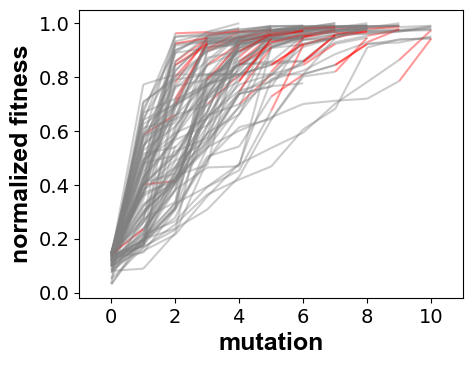

In [8]:
#############################################
## now for plotting a sample of random walks
#############################################

random.seed(435987)

Narr=[1e+08]    

# the number of walks to plot, anything more than a few hundred will be too cluttered
nwalks=100
walklen=10


#the percentile in the fitness distribution below which starting genotypes should be chosen
#perc=100 means they are chosen randomly without regard to fitness
perc=5
tmpfitarr=[]
for i in range(0,len(gnet.vs)):
    tmpfitarr.append(gnet.vs[i]['fit'])
thresh=np.percentile(tmpfitarr, perc)

node_sample=gnet.vs.select(fit_le=thresh)
print("sampling ", nwalks, "nodes from a subset of ", len(node_sample), "nodes in the ", perc, "-percentile of the fitness distribution")

ranwalkdat=pd.DataFrame([i for i in range(0,walklen+1)], index=[i for i in range(0,walklen+1)], columns=['step'])
for N in Narr:
    #calculate the fixation probabilities along all edges of the genotpe network
    EE_funcs.pfix_gnet_Kimura(gnet, N)

    g_init=random.choices(node_sample, k=nwalks)
    walkctr=0
    evolvdat={} #maps the fitness data containing columns onto the evolbability
                #data containing columns
    fitcolnamearr=[] #array of all those column names that contain fitness data
    evolvcolnamearr=[] #array of all those column names that contain evolvability data
    for g in g_init:
        walkctr+=1
        initfit=g['fit']
        
        #compute the random walks proper
        [fitarr, evolvarr]=EE_funcs.ranwalk_Kimura_verbose(gnet, g, walklen)
               
        fitarr.insert(0, initfit)
        #normalize fitness values to (0,1)
        fitarr=(np.array(fitarr)-minfit_lite)/(maxfit_lite-minfit_lite)
                
        ranwalkdat['w_'+str(walkctr) ] = pd.Series(fitarr)
        ranwalkdat['e_'+str(walkctr)] = pd.Series(evolvarr)        
        evolvdat['w_'+str(walkctr)]='e_'+str(walkctr)

        fitcolnamearr.append('w_'+str(walkctr))
        evolvcolnamearr.append('e_'+str(walkctr))
        

#determine the actual minimum and maximum fitness during the walk, 
#do this before substituting the numerical values further below
minfit=1
maxfit=-1
for col in sorted(evolvdat.keys()):
    tmpminfit=ranwalkdat[col].min()
    tmpmaxfit=ranwalkdat[col].max()
    if tmpminfit<minfit:
        minfit=tmpminfit
    if tmpmaxfit>maxfit:
        maxfit=tmpmaxfit

#now for plotting the data
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
#replace the indicators of evolvability with integers for mapping onto colors
ranwalkdat.replace("ED", 0, inplace=True)
ranwalkdat.replace("EN", 1, inplace=True)
ranwalkdat.replace("EE", 2, inplace=True)

cmap = ListedColormap(['grey', 'grey', 'red'])
norm = BoundaryNorm(range(4), cmap.N)

fig1 = plt.figure()
for col in sorted(evolvdat.keys()):
    points = np.array([ranwalkdat.index, ranwalkdat[col]]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, cmap=cmap, norm=norm, alpha=0.4)
    lc.set_array(ranwalkdat[evolvdat[col]])
    plt.gca().add_collection(lc)
    
plt.xlabel("mutation", fontname="Arial", fontsize = 18, fontweight = 'bold')
plt.ylabel("normalized fitness", fontname="Arial", fontsize = 18, fontweight = 'bold')
plt.tick_params(axis='both', labelcolor='black', labelsize=14)

plt.xlim(ranwalkdat.index.min()-1, ranwalkdat.index.max()+1)
plt.ylim(minfit-0.05, maxfit+0.05)
plt.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.2)

plt.show()

 
